# Mt Wilson Sunspot database 1917-1985

From the readme: 

> Sunspot umbral position and area information were digitized from the Mount Wilson daily white-light solar images some years ago (Howard, Gilman, and Gilman, 1984). These photographic images exist in a series that extends from 1917 through the present time. The digitized data extend from 1917 through 1985. Details about the observations, the measurement procedure, and the analysis techniques used earlier may be obtained from the earlier reference (Howard, Gilman, and Gilman, 1984).

These data were first published in [Howard, Gilman, and Gilman, 1984](http://adsabs.harvard.edu/abs/1984ApJ...283..373H). The data are accessible online [here](http://www.ngdc.noaa.gov/stp/solar/sunspotregionsdata.html).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

paths = glob('/Users/bmmorris/data/Mt_Wilson_Tilt/*/gspot??.dat')

from astropy.time import Time
import astropy.units as u
import string
from astropy.table import Table

def split_interval(string, n, cast_to_type=float):
    return [cast_to_type(string[i:i+n]) for i in range(0, len(string), n)]

base_time = Time('1915-01-01')
all_years_array = []

header = ("jd n_spots_leading n_spots_following n_spots_day_1 n_spots_day_2 "
          "rotation_rate latitude_drift area_weighted_latitude_day_1 area_weighted_longitude_day_1 "
          "area_weighted_longitude_day_2 area_day_1 area_day_2 tilt_day_1 delta_polarity_separation "
          "area_weighted_longitude_day_1_leading area_weighted_longitude_day_1_following "
          "area_weighted_latitude_day_1_leading area_weighted_latitude_day_1_following "
          "area_leading area_following area_weighted_longitude_day_2_leading " 
          "area_weighted_longitude_day_2_following delta_tilt").split()

for path in paths:
    f = open(path).read().splitlines()

    n_rows = len(f) // 3
    n_columns = 23
    yearly_array = np.zeros((n_rows, n_columns))

    for i in range(n_rows):
        # First five ints specify time, afterwards specify sunspot data
        int_list = split_interval(f[0+i*3][:18], 2, int)
        month, day, year_minus_1900, hour, minute = int_list[:5]
        year = year_minus_1900 + 1900
        jd = Time("{year:d}-{month:02d}-{day:02d} {hour:02d}:{minute:02d}"
                  .format(**locals())).jd
        row = [jd] + int_list[5:] + split_interval(f[1+i*3], 7) + split_interval(f[2+i*3][1:], 7)
        yearly_array[i, :] = row

    all_years_array.append(yearly_array)

table = Table(np.vstack(all_years_array), names=header)

In [2]:
table

jd,n_spots_leading,n_spots_following,n_spots_day_1,n_spots_day_2,rotation_rate,latitude_drift,area_weighted_latitude_day_1,area_weighted_longitude_day_1,area_weighted_longitude_day_2,area_day_1,area_day_2,tilt_day_1,delta_polarity_separation,area_weighted_longitude_day_1_leading,area_weighted_longitude_day_1_following,area_weighted_latitude_day_1_leading,area_weighted_latitude_day_1_following,area_leading,area_following,area_weighted_longitude_day_2_leading,area_weighted_longitude_day_2_following,delta_tilt
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2421232.78125,1.0,1.0,2.0,3.0,13.151,0.417,13.142,-11.249,0.314,19.615,13.818,-25.35,-0.372,-10.382,-11.392,13.542,13.076,2.778,16.837,0.919,0.269,-2.74
2421232.78125,1.0,1.0,2.0,2.0,13.568,0.464,13.207,-4.112,7.847,9.468,20.938,13.468,0.11,-3.352,-4.209,13.029,13.229,1.068,8.4,7.863,6.944,-36.03
2421232.78125,1.0,3.0,4.0,12.0,12.176,1.184,13.705,18.61,29.247,46.216,58.587,-2.183,0.829,19.616,17.678,13.742,13.67,22.228,23.988,30.838,28.035,-0.8
2421233.83056,2.0,1.0,3.0,2.0,13.864,0.778,13.538,0.314,13.619,13.818,9.298,-28.093,0.147,0.919,0.269,13.852,13.515,0.949,12.869,14.261,13.404,12.33
2421233.83056,1.0,1.0,2.0,3.0,14.073,0.093,13.648,7.847,21.368,20.938,10.639,-22.565,-0.434,7.863,6.944,13.654,13.283,20.572,0.366,21.397,21.17,-43.1
2421233.83056,2.0,10.0,12.0,5.0,14.615,0.466,14.829,29.247,43.327,58.587,33.791,-2.981,-0.788,30.838,28.035,14.909,14.768,25.322,33.264,44.099,42.146,-9.04
2421234.79792,0.0,0.0,1.0,4.0,13.76,0.132,-22.199,-28.179,-15.905,3.542,2.573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-16.143,0.0
2421234.79792,1.0,1.0,2.0,3.0,14.281,-0.386,14.341,13.619,26.394,9.298,20.175,-15.763,-0.251,14.261,13.404,14.516,14.282,2.331,6.967,26.754,26.136,4.41
2421234.79792,1.0,2.0,3.0,3.0,14.197,-0.751,13.744,21.368,34.063,10.639,14.355,-65.662,0.493,21.397,21.17,13.805,13.319,9.298,1.34,34.45,33.594,30.02


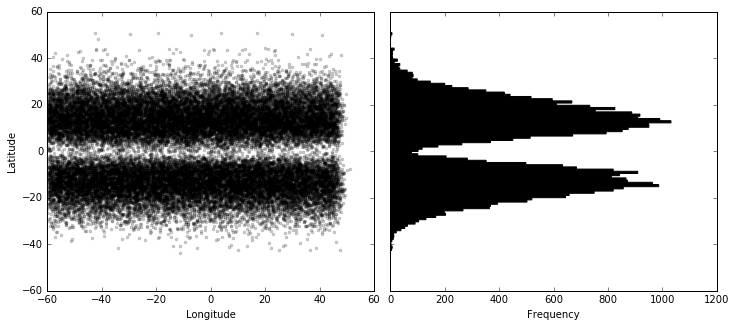

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
ax[0].plot(table['area_weighted_longitude_day_1'], 
           table['area_weighted_latitude_day_1'], 'k.', alpha=0.2)
ax[1].hist(table['area_weighted_latitude_day_1'], 100, 
           histtype='stepfilled', color='k', orientation='horizontal')

ax[0].set(xlabel='Longitude', ylabel='Latitude')
ax[1].set(xlabel='Frequency')
fig.subplots_adjust(wspace=0.05)
plt.show()

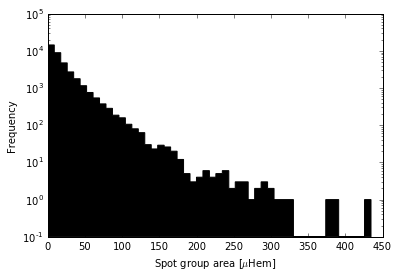

In [4]:
plt.hist(table['area_day_1'], 50, log=True, histtype='stepfilled', color='k')
plt.xlabel('Spot group area [$\mu$Hem]')
plt.ylabel('Frequency')
plt.show()

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


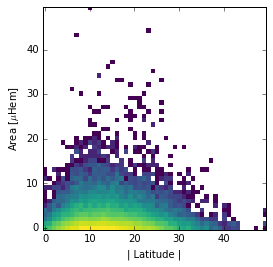

In [5]:
img, xedges, yedges = np.histogram2d(table['area_day_1'], 
                                     np.abs(table['area_weighted_latitude_day_1']), 50)
plt.imshow(np.log(img), cmap=plt.cm.viridis, interpolation='nearest', origin='lower')
plt.xlabel('| Latitude |')
plt.ylabel('Area [$\mu$Hem]')
plt.show()